In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score

In [2]:
animal_dir = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"
len(os.listdir(animal_dir))

90

In [3]:
with open("/kaggle/input/animal-image-dataset-90-different-animals/name of the animals.txt", 'r') as f:
    animal_info = f.read()
print(animal_info.split())

['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


In [4]:
animal_names = {} 
animal_directories = os.listdir(animal_dir)

for animal_name in animal_directories:
    animal_path = os.path.join(animal_dir, animal_name)
    num_images = len(os.listdir(animal_path))
    animal_names[animal_name] = num_images

In [5]:
path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

In [ ]:
animal_names = {} 
animal_directories = os.listdir(path)

for animal_name in animal_directories:
    animal_path = os.path.join(path, animal_name)
    num_images = len(os.listdir(animal_path))
    animal_names[animal_name] = num_images

In [14]:
class dataset_new(Dataset):
    def __init__(self,data_idx,take=0.1,path=path):
        super().__init__()
        classes = os.listdir(path)
        folder_name = classes[data_idx]
        self.images = []
        self.labels = []
        self.transforms = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        for folder in classes:
            if folder==folder_name:
                limit = 1
            else:
                limit = take
            anim_fold = os.path.join(path, folder)
            for l,localpath in enumerate(os.listdir(anim_fold)):
                if(l>=limit*len(os.listdir(anim_fold))):
                    break
                img_path = os.path.join(anim_fold, localpath)
                self.images.append(img_path)
                if folder==folder_name:
                    self.labels.append(1)
                else:
                    self.labels.append(0)
        
    def __len__(self):
        return len(self.images)
    def __getitem__(self,idx):
        img = Image.open(self.images[idx])
        label = self.labels[idx]
        return self.transforms(img), torch.tensor(label,dtype=torch.long)
      

In [22]:
def run_label_classification_one_vs_rest_fold(model_net):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     name_model = str(name)
    for i in range(90):
        print(animal_info.split()[i])
        dataset = dataset_new(i)

        kfold = KFold(n_splits=3, shuffle=True)

        print('--------------------------------')

        for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

            print(f'FOLD {fold}')
            print('--------------------------------')

            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
            test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

            train_loader = DataLoader(dataset, batch_size=32, sampler=train_subsampler, pin_memory=True, num_workers=2)
            test_loader = DataLoader(dataset, batch_size=32, sampler=test_subsampler, pin_memory=True, num_workers=2)

            model = model_net
            model.to(device)

            optimizer = optim.Adam(model.parameters(), lr=0.0005)
            train_losses = []
            test_losses = []
            train_accuracies = []
            test_accuracies = []

            for epoch in range(3):

                model.train()
                correct = 0
                total = 0
                train_loss = 0.0
                for _, (inputs, labels) in enumerate(train_loader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    outputs = model(inputs)
                    loss = nn.CrossEntropyLoss()(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

                model.eval()  
                test_loss = 0.0
                test_correct = 0
                test_total = 0
                all_labels = []
                all_predictions = []

                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = nn.CrossEntropyLoss()(outputs, labels)
                    test_loss += loss.item()*inputs.size(0)
                    _, predicted = outputs.max(1)
                    test_total += labels.size(0)
                    test_correct += predicted.eq(labels).sum().item()
                    all_labels.extend(labels.cpu().numpy())
                    all_predictions.extend(predicted.cpu().numpy())


                test_loss = test_loss / len(test_loader)
                train_loss = train_loss/len(train_loader)
                test_accuracy = 100.0 * correct / total
                train_accuracy = 100.0 * test_correct/test_total

                train_losses.append(train_loss)
                test_losses.append(test_loss)
                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)

                print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f} \tTrain Accuracy {:.6f}% \tTest Accuracy: {:.2f}%'.format(
                    epoch+1, 
                    train_loss,
                    test_loss,
                    train_accuracy,
                    test_accuracy
                    ))
                

            plt.figure(figsize=(10, 5))
            plt.plot(train_accuracies, label='Train Accuracy')
            plt.plot(test_accuracies, label='Test Accuracy')
            plt.title('Accuracy Curve for Dataset Name: {} Fold {}'.format(animal_info.split()[i], fold))
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')

            print('Confusion Matrix for fold {}'.format(fold))
            print(confusion_matrix(all_labels, all_predictions))


antelope
--------------------------------
FOLD 0
--------------------------------
Epoch: 1 	Training Loss: 0.728858 	Test Loss: 21.314064 	Train Accuracy 15.151515% 	Test Accuracy: 54.80%
Epoch: 2 	Training Loss: 0.625024 	Test Loss: 18.875517 	Train Accuracy 65.656566% 	Test Accuracy: 73.74%
Epoch: 3 	Training Loss: 0.570384 	Test Loss: 16.842420 	Train Accuracy 76.262626% 	Test Accuracy: 76.77%
Confusion Matrix for fold 0
[[141  40]
 [  7  10]]
FOLD 1
--------------------------------
Epoch: 1 	Training Loss: 0.644926 	Test Loss: 16.962916 	Train Accuracy 72.222222% 	Test Accuracy: 69.19%
Epoch: 2 	Training Loss: 0.583670 	Test Loss: 16.471706 	Train Accuracy 74.747475% 	Test Accuracy: 79.29%
Epoch: 3 	Training Loss: 0.528762 	Test Loss: 21.933037 	Train Accuracy 44.444444% 	Test Accuracy: 83.84%
Confusion Matrix for fold 1
[[ 65 110]
 [  0  23]]
FOLD 2
--------------------------------
Epoch: 1 	Training Loss: 0.553637 	Test Loss: 13.172599 	Train Accuracy 83.333333% 	Test Accuracy: 7

/tmp/ipykernel_34/2872808351.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


--------------------------------
FOLD 0
--------------------------------
Epoch: 1 	Training Loss: 0.428500 	Test Loss: 6.414480 	Train Accuracy 95.959596% 	Test Accuracy: 87.63%
Epoch: 2 	Training Loss: 0.324723 	Test Loss: 9.267476 	Train Accuracy 92.929293% 	Test Accuracy: 93.94%
Epoch: 3 	Training Loss: 0.292678 	Test Loss: 11.398525 	Train Accuracy 87.878788% 	Test Accuracy: 95.45%
Confusion Matrix for fold 0
[[156  24]
 [  0  18]]
FOLD 1
--------------------------------
Epoch: 1 	Training Loss: 0.284785 	Test Loss: 8.178799 	Train Accuracy 93.939394% 	Test Accuracy: 95.96%
Epoch: 2 	Training Loss: 0.248312 	Test Loss: 11.444464 	Train Accuracy 90.404040% 	Test Accuracy: 97.22%
Epoch: 3 	Training Loss: 0.229469 	Test Loss: 8.587274 	Train Accuracy 94.949495% 	Test Accuracy: 98.74%
Confusion Matrix for fold 1
[[166   9]
 [  1  22]]
FOLD 2
--------------------------------
Epoch: 1 	Training Loss: 0.273030 	Test Loss: 5.029275 	Train Accuracy 100.000000% 	Test Accuracy: 94.19%
Epoch: 

KeyboardInterrupt: 

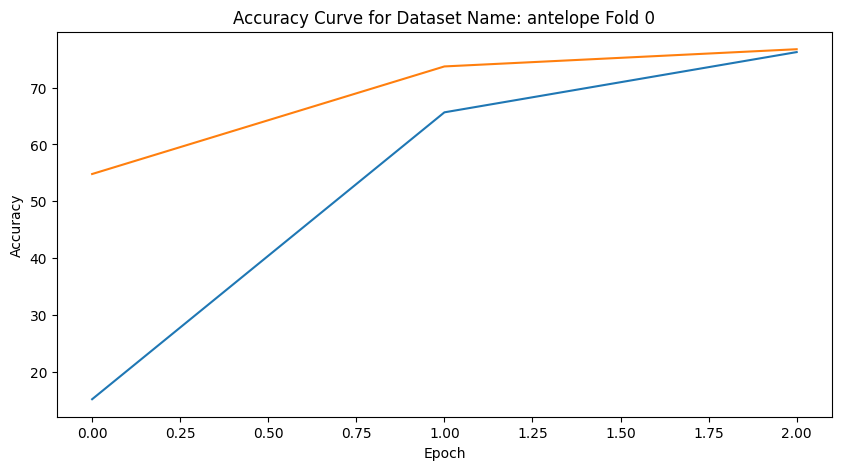

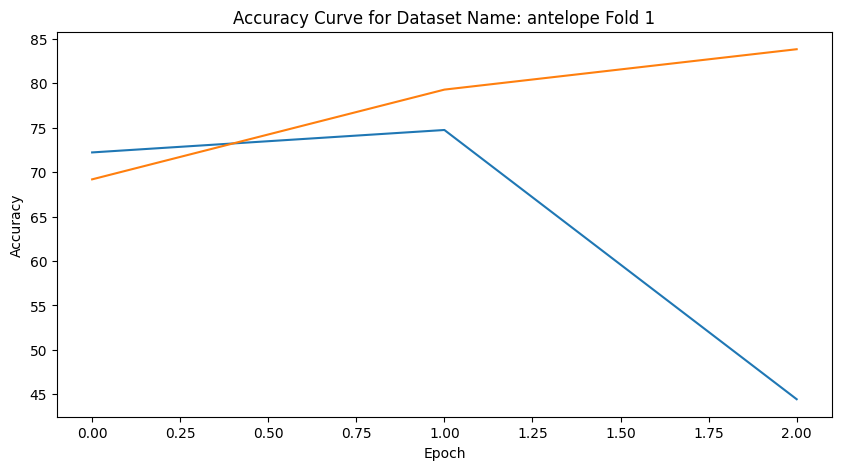

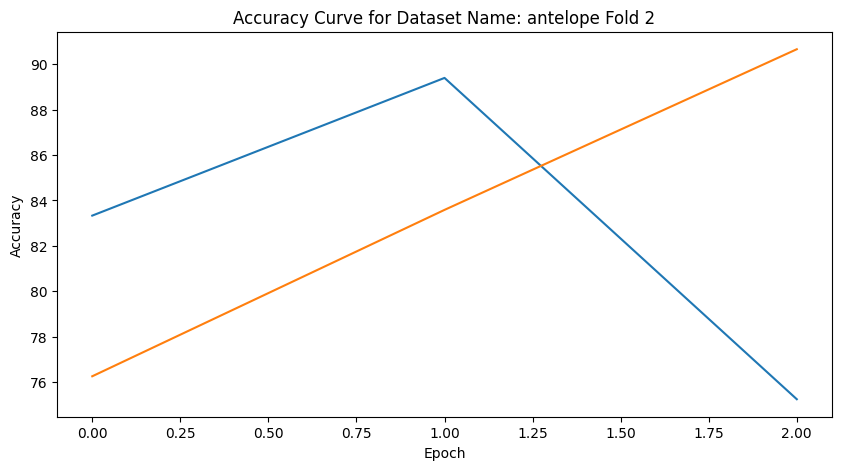

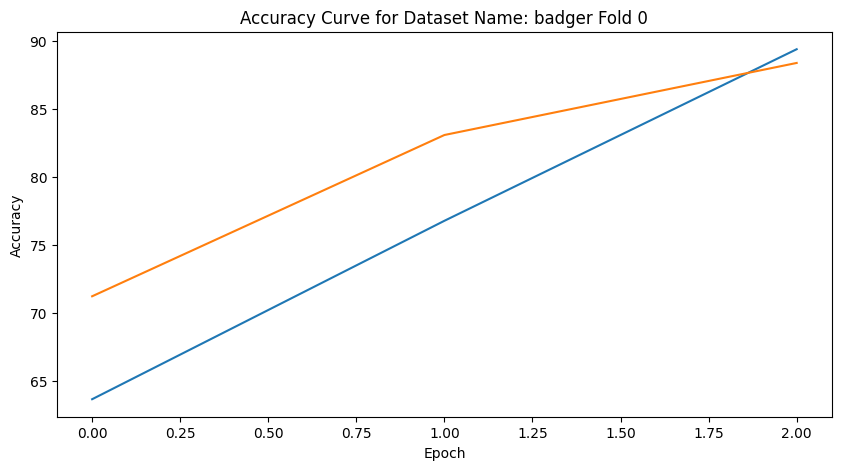

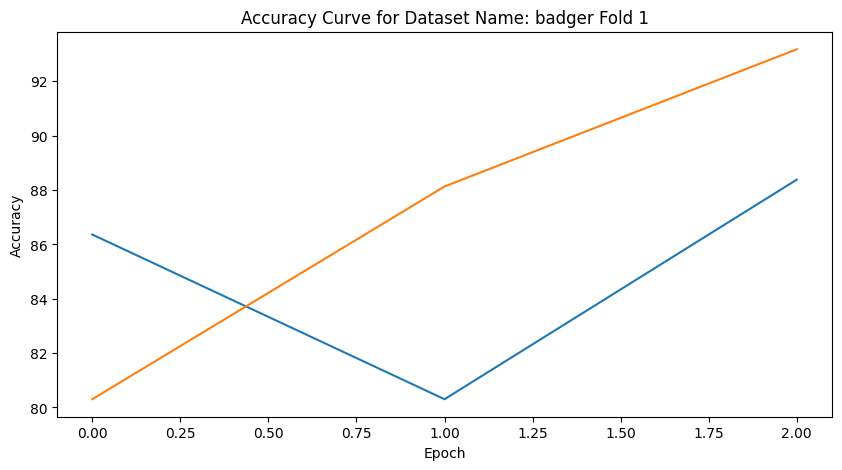

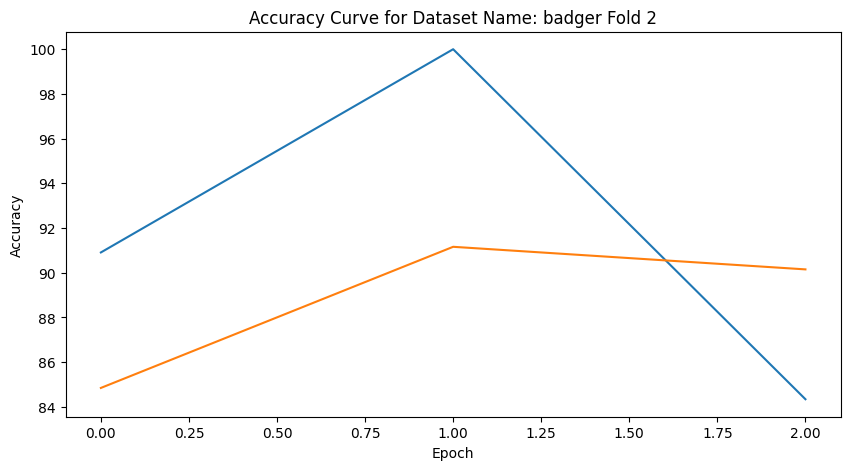

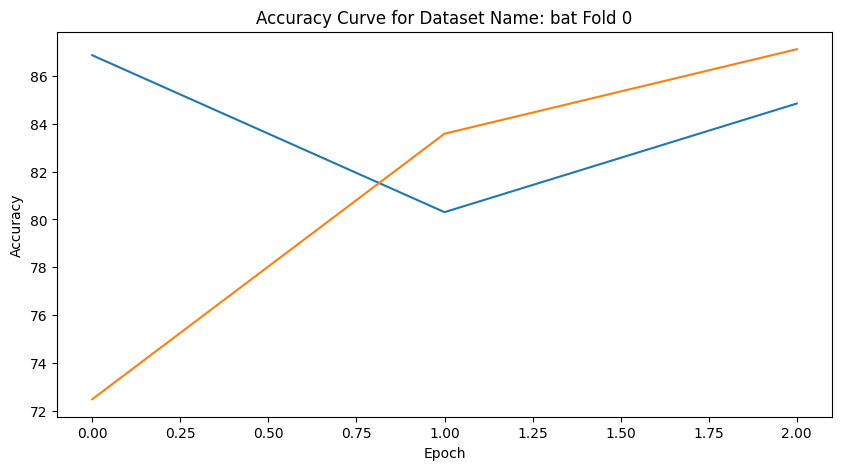

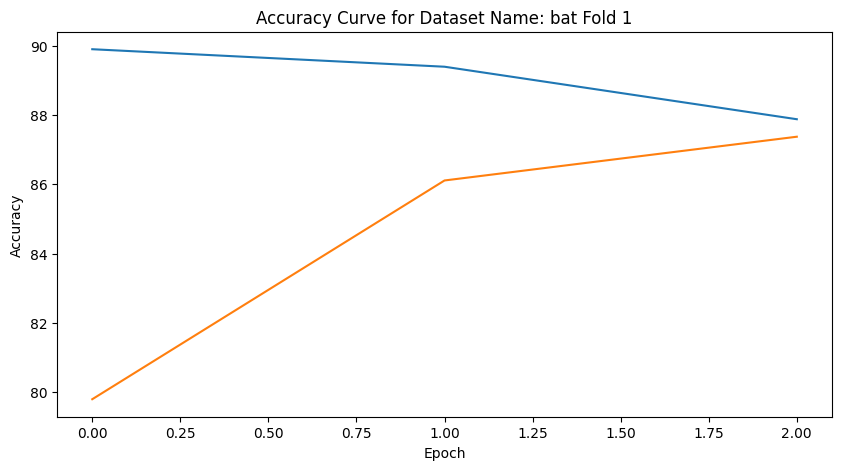

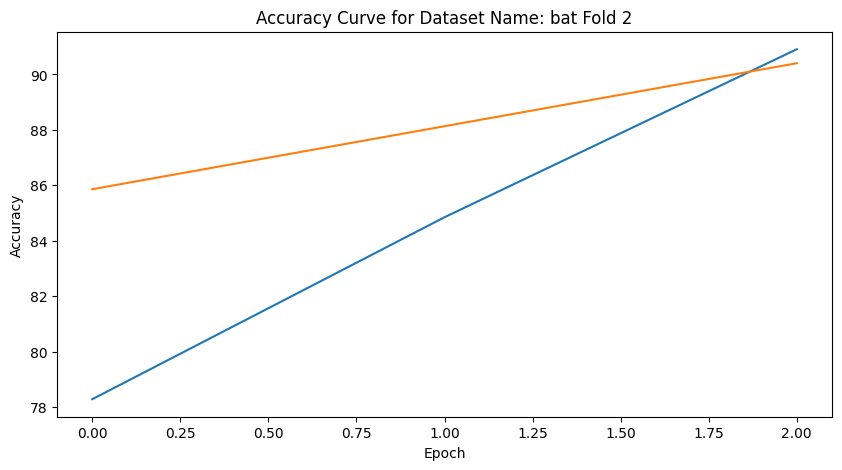

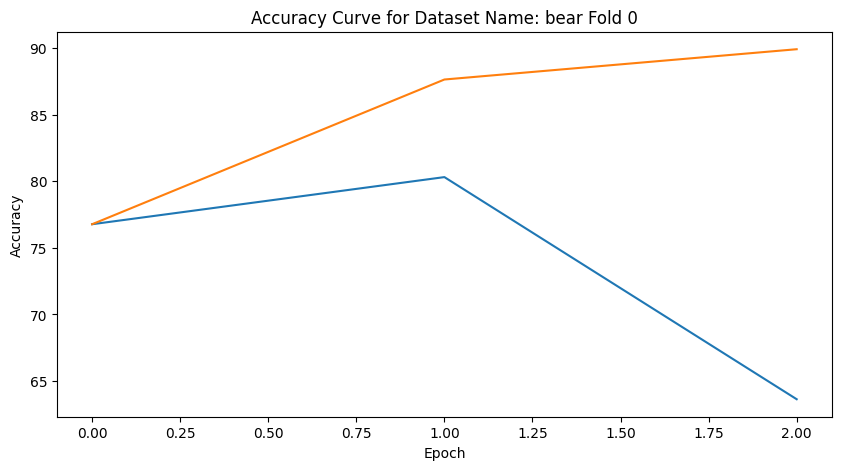

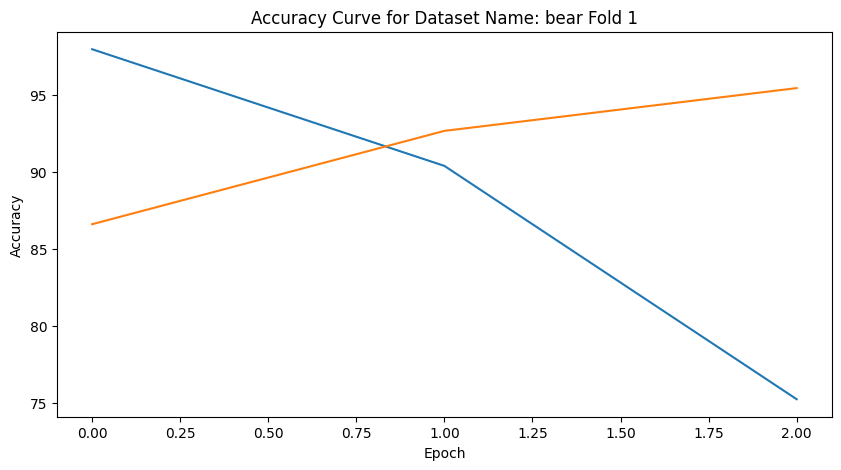

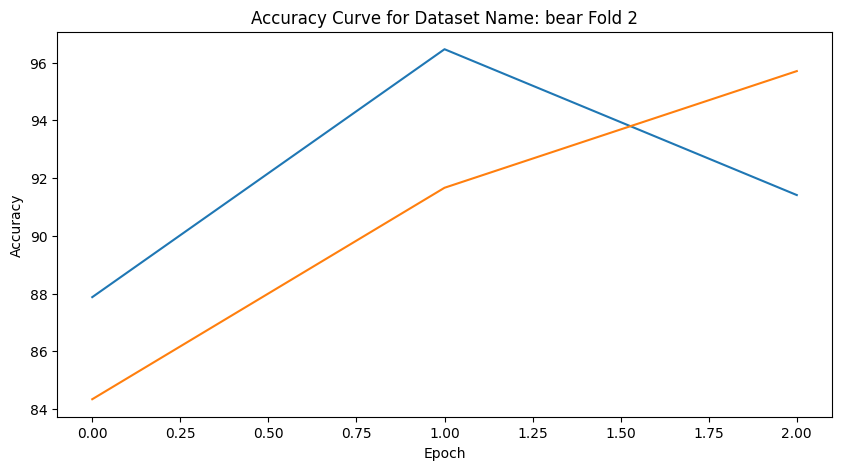

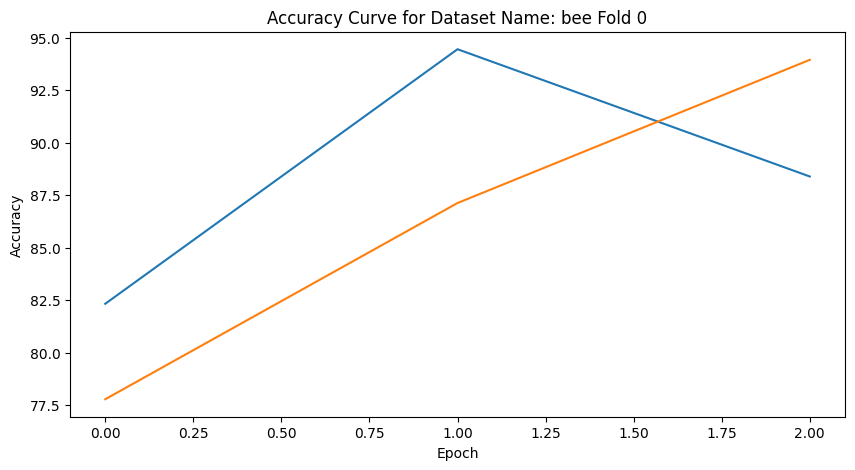

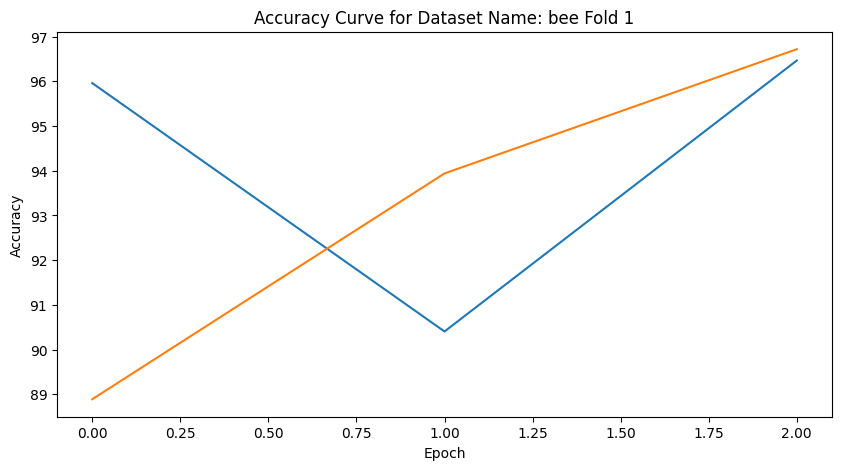

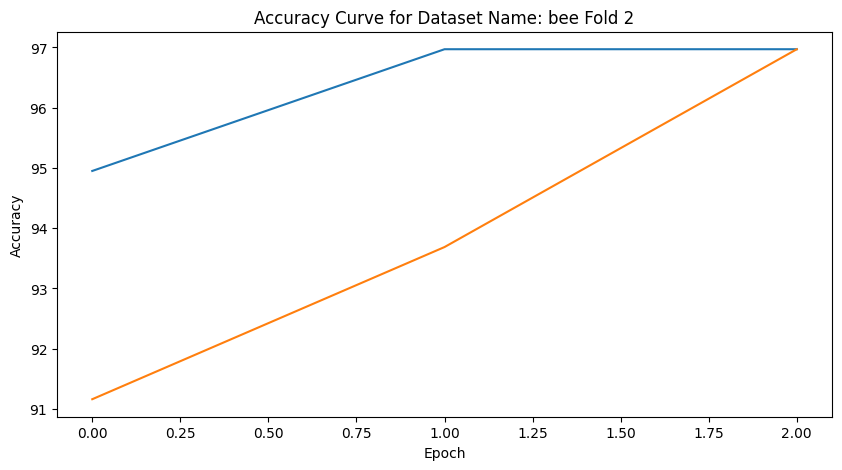

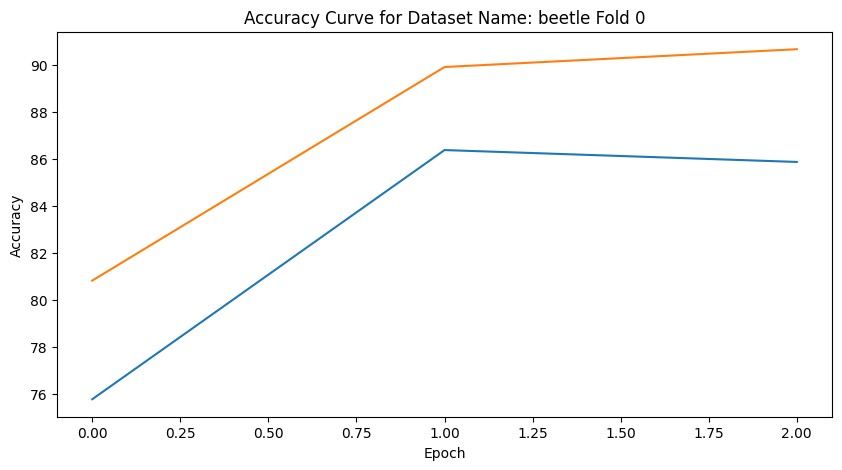

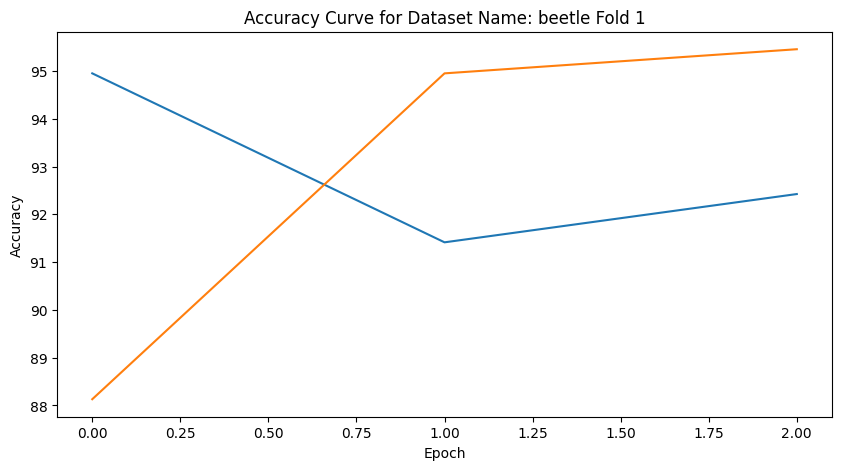

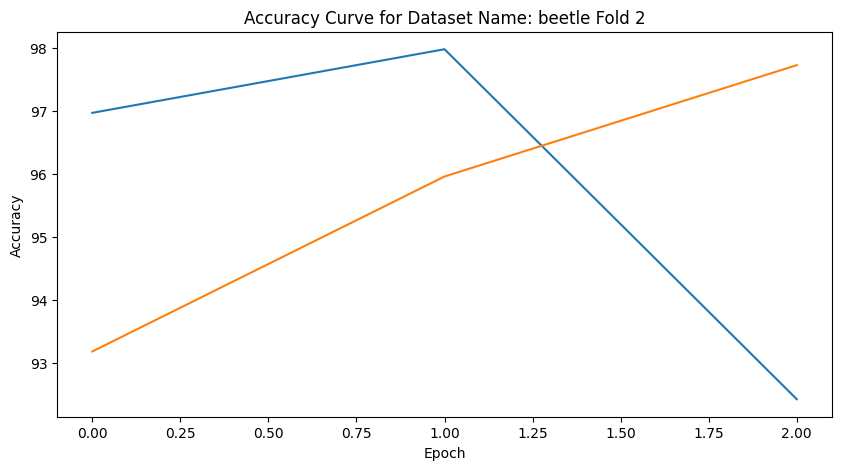

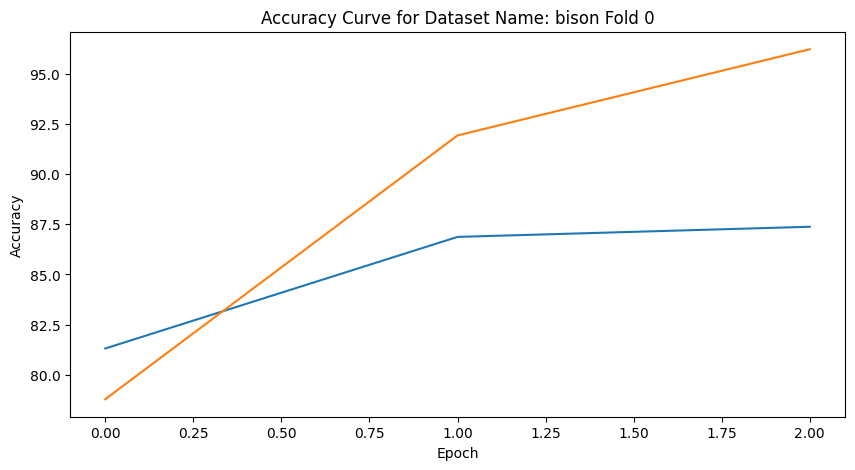

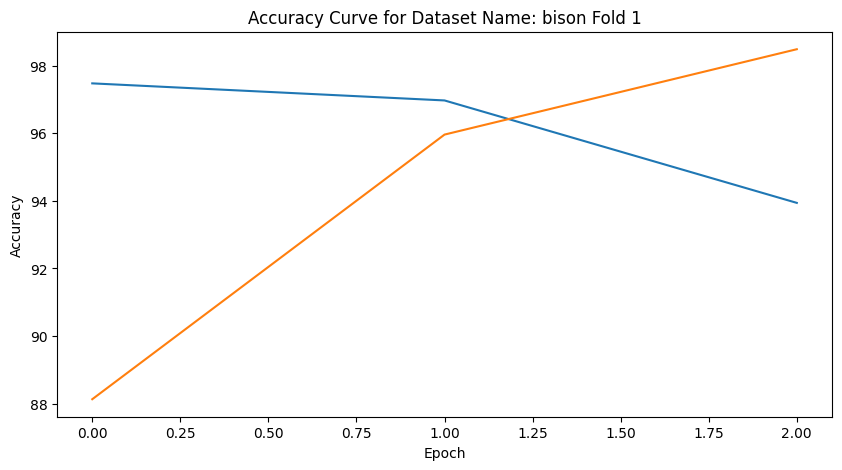

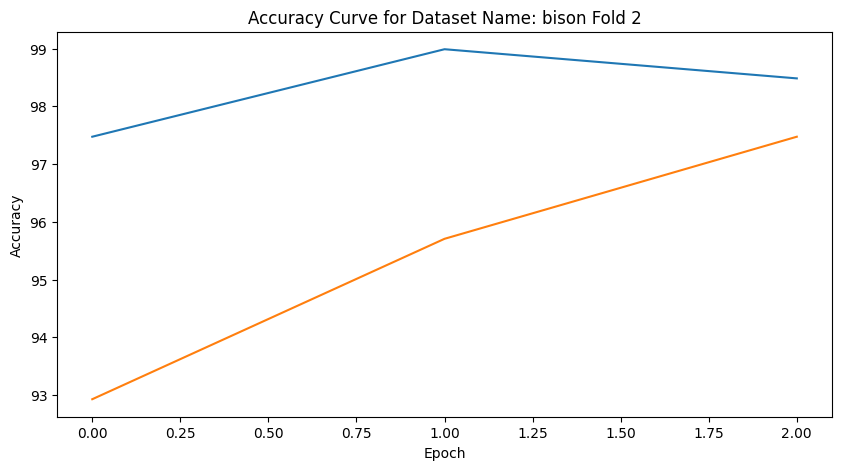

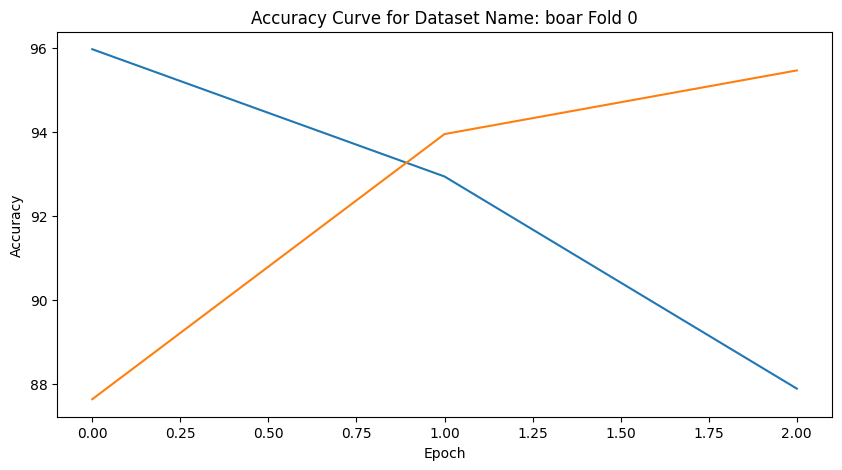

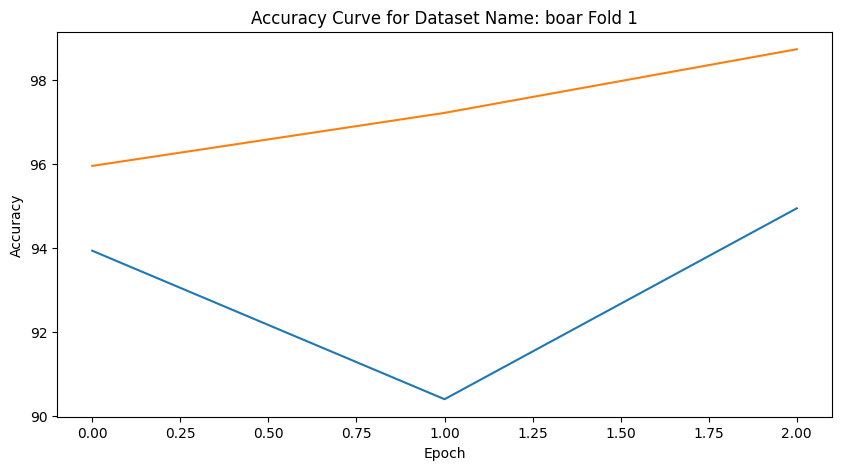

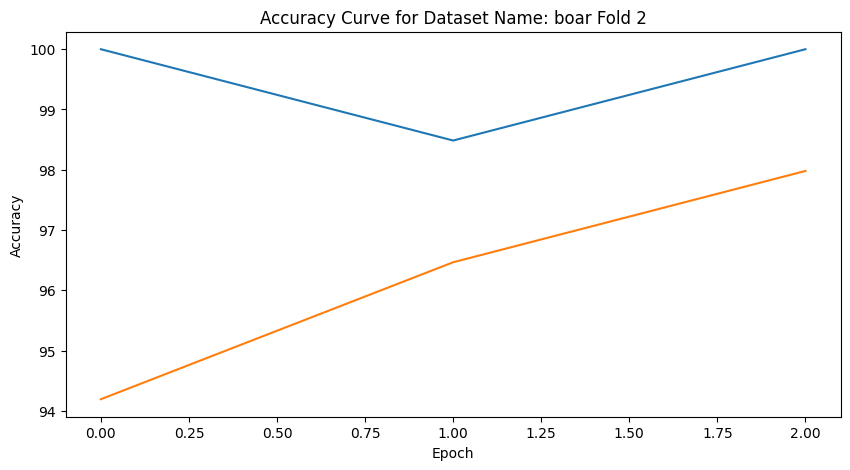

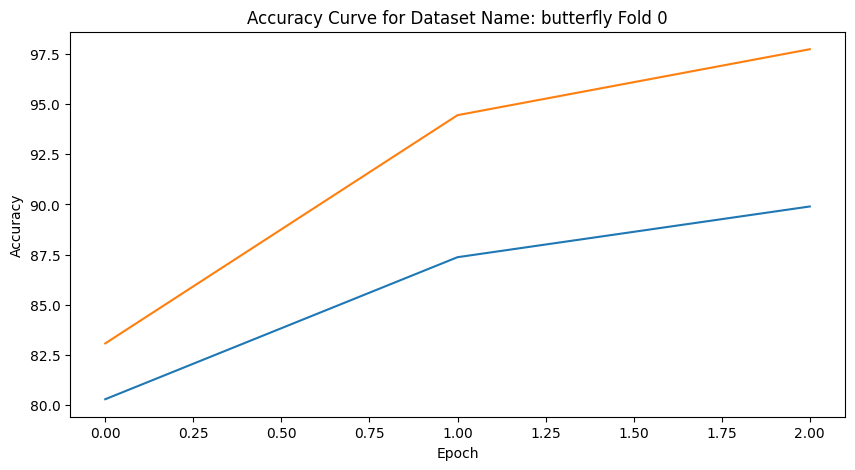

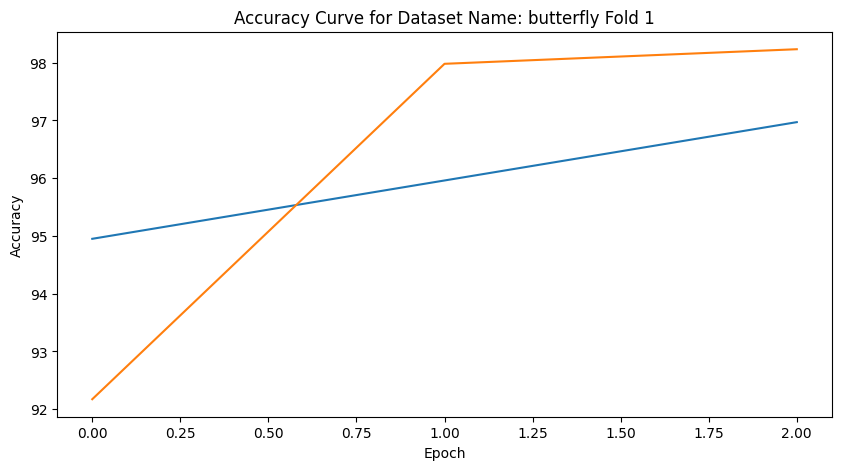

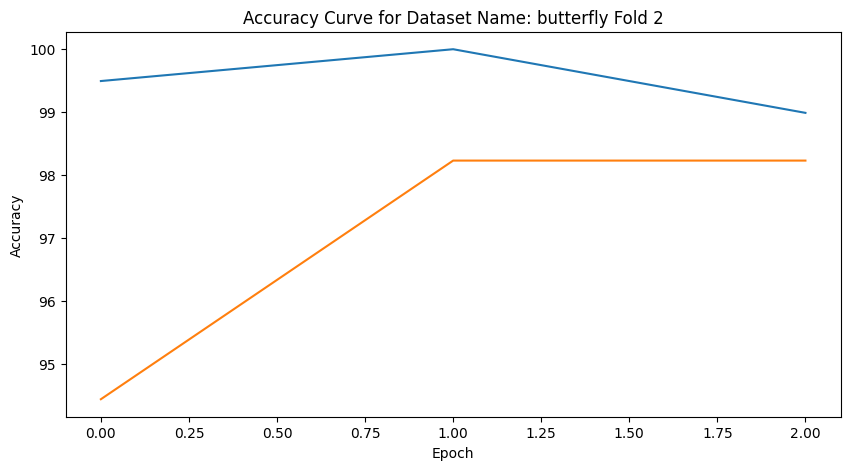

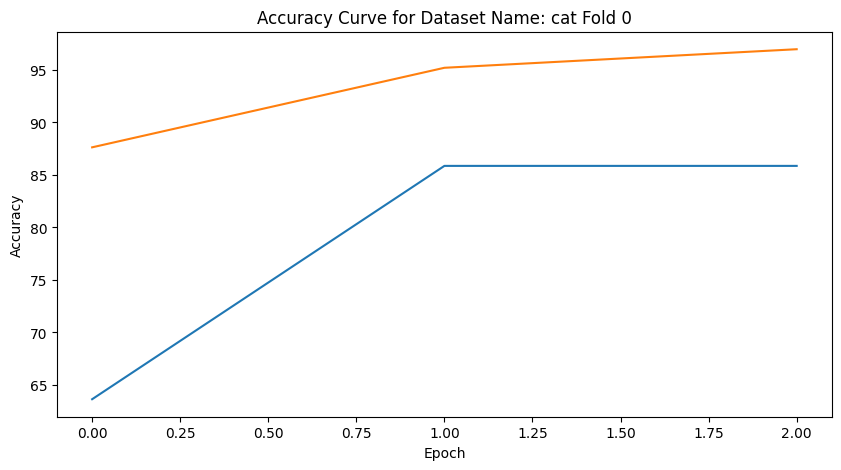

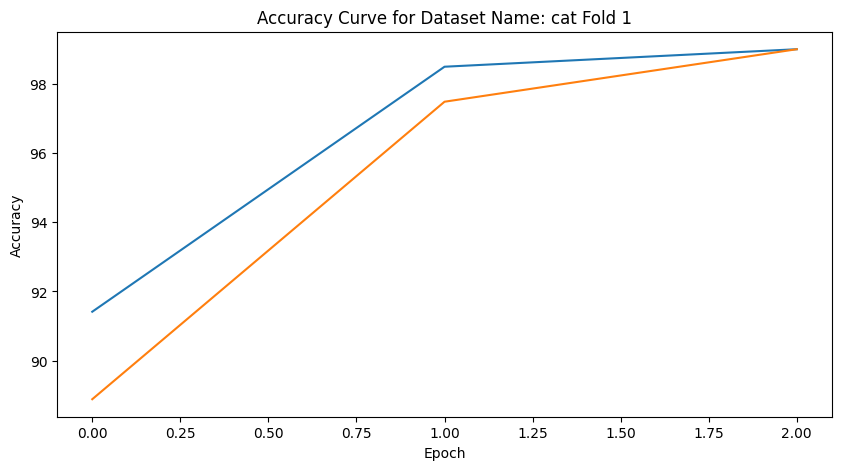

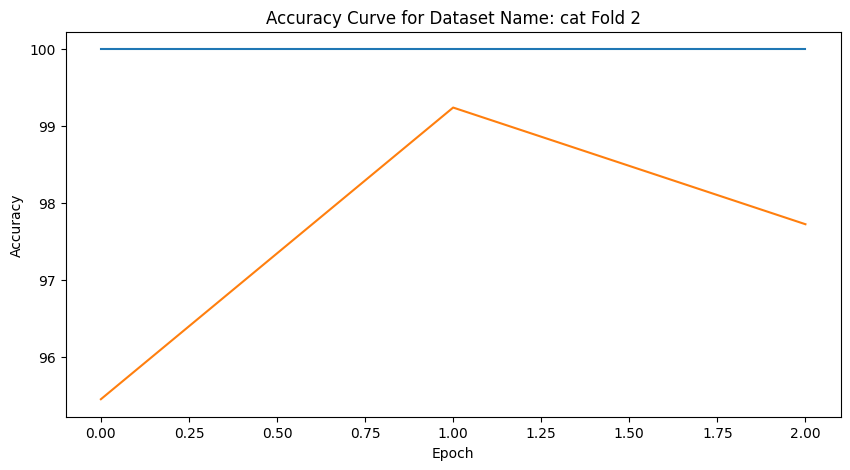

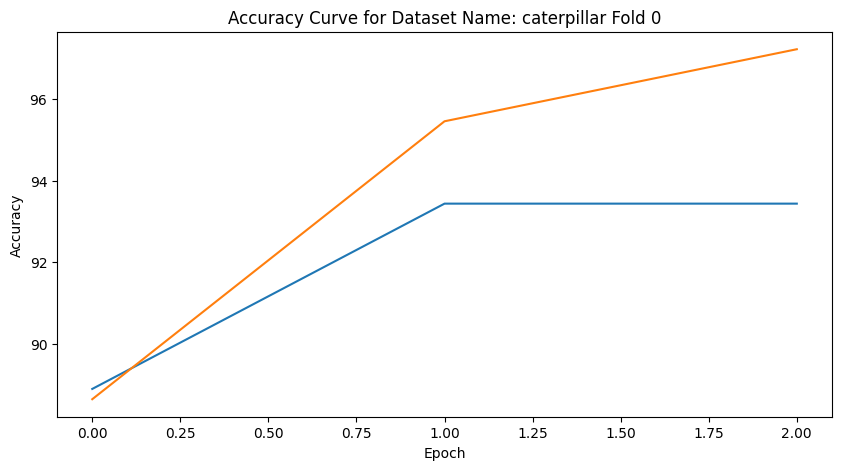

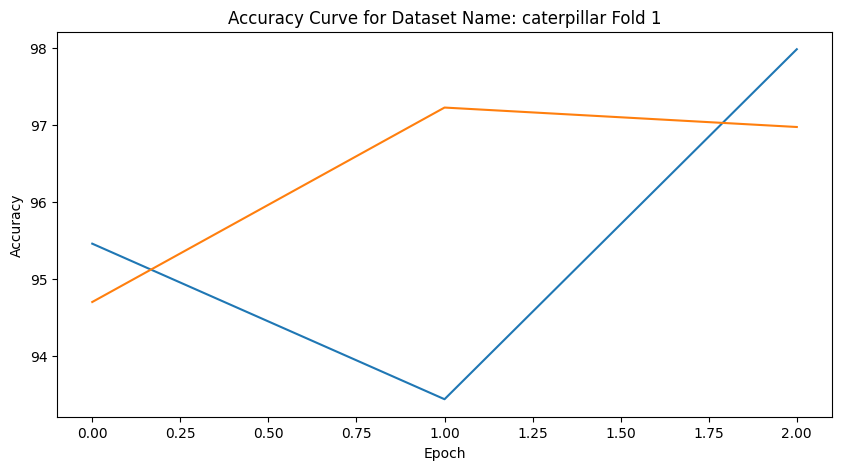

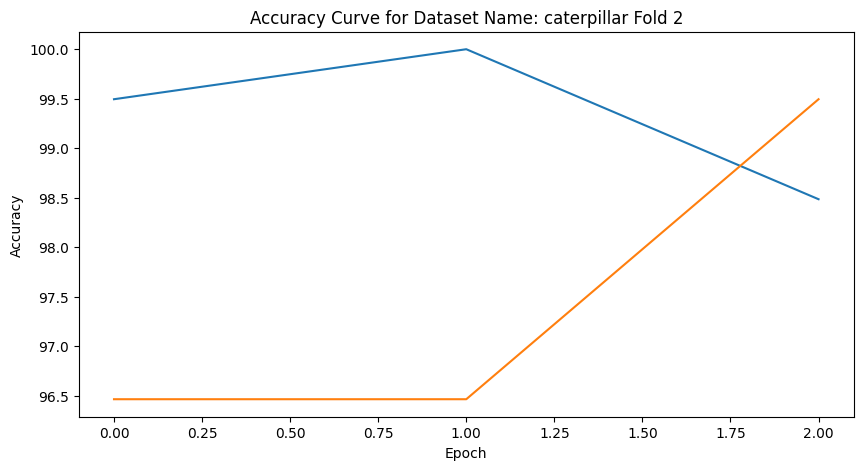

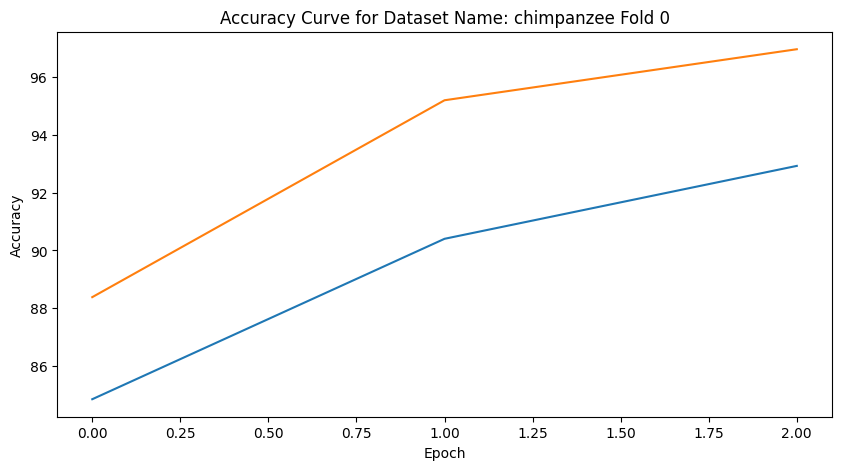

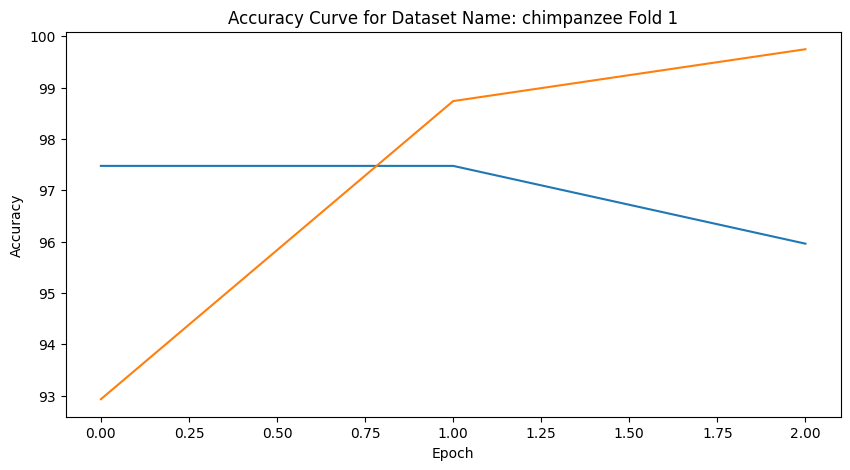

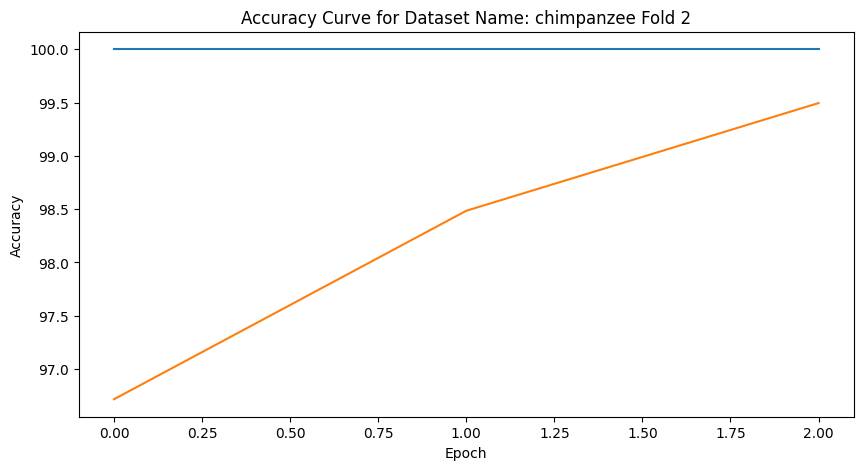

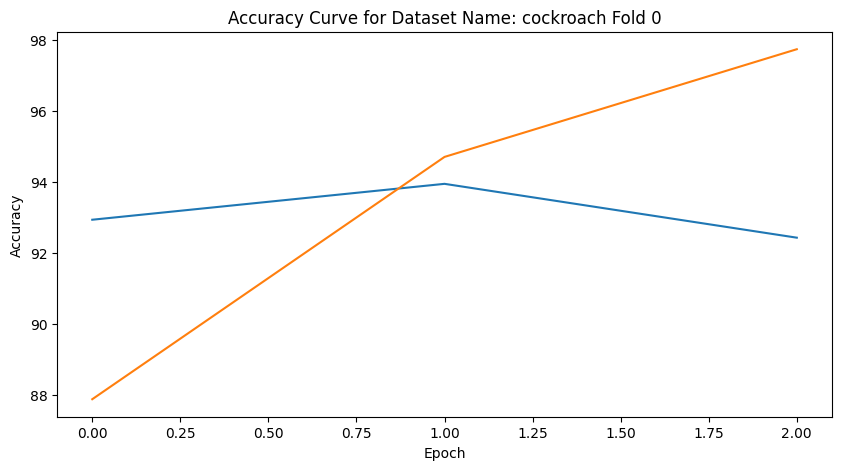

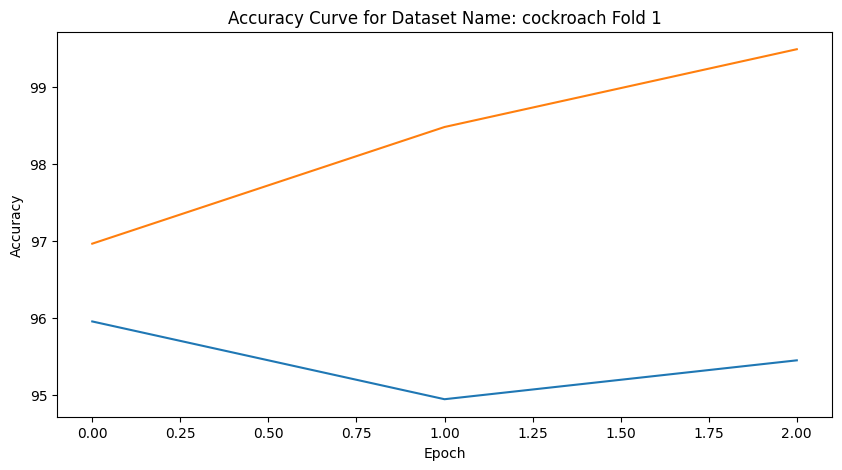

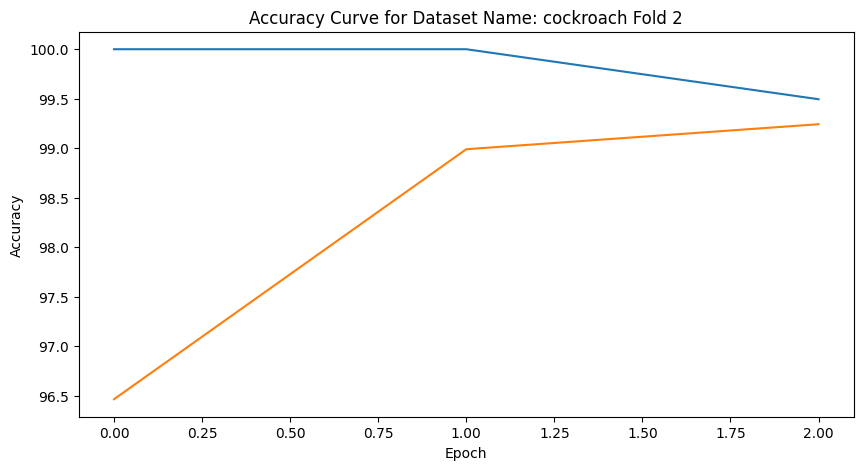

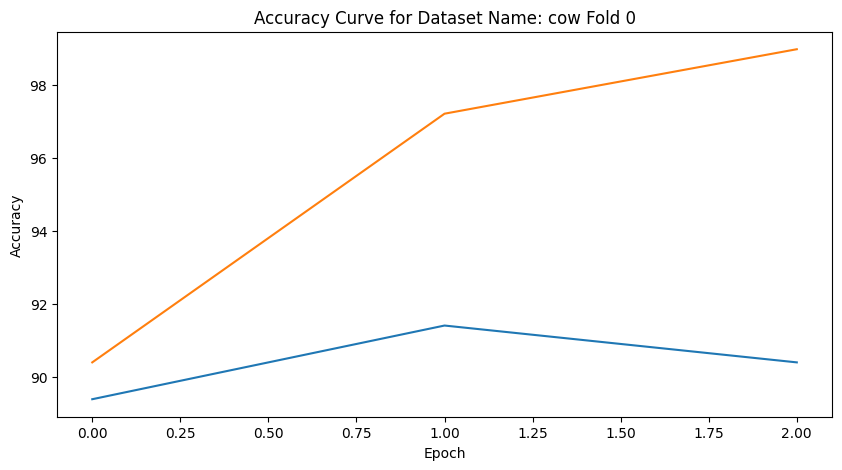

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu=nn.ReLU()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=8, kernel_size=(3,3), stride=1, padding=0)
        self.bn1=nn.BatchNorm2d(8)
        self.mp1=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.conv2=nn.Conv2d(in_channels=8,out_channels=16, kernel_size=(3,3), stride=1, padding=0)
        self.bn2=nn.BatchNorm2d(16)
        self.mp2=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.conv3=nn.Conv2d(in_channels=16,out_channels=16, kernel_size=(7,7), stride=1, padding=0)
        self.bn3=nn.BatchNorm2d(16)
        self.mp3=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)

        self.conv4=nn.Conv2d(in_channels=16,out_channels=32, kernel_size=(5,5), stride=1, padding=0)
        self.bn4=nn.BatchNorm2d(32)
        self.mp4=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
               
        self.flatten=nn.Flatten()

        self.lin1=nn.Linear(in_features=4608, out_features=64)
        self.bn5=nn.BatchNorm1d(num_features=64)
        self.lin2=nn.Linear(in_features=64, out_features=2)
        self.bn6=nn.BatchNorm1d(num_features=2)
            
    def forward(self,x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.mp1(x)
        
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu(x)
        x=self.mp2(x)
        
        x=self.conv3(x)
        x=self.bn3(x)
        x=self.relu(x)
        x=self.mp3(x)

        x=self.conv4(x)
        x=self.bn4(x)
        x=self.relu(x)
        x=self.mp4(x)

        x=self.flatten(x)

        x=self.lin1(x)
        x=self.bn5(x)
        x=self.relu(x)
        x=self.lin2(x)
        output=self.bn6(x)

        return output

model = CNN()
run_label_classification_one_vs_rest_fold(model)

The above epochs shows that the model is learning gradually from training accuracies as well as confusion matrix plots.
In accuracy plots, blue line show training accuracy and orange is for testing...the graph shows us that training is happening in idealistic manner
Further...there are more animals left, but I stopped training as it will be waste of time...our model is working well enough

## 5 Class Classification

In [24]:
class dataset_pent_class(Dataset):
    def __init__(self,start_idx, path=path, window_size= 5):
        super().__init__()
        classes = os.listdir(path)
        self.images = []
        self.labels = []
        self.transforms = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        end_idx = start_idx*5 + window_size
        for i in range(start_idx*5, end_idx):
            folder_name = classes[i] 
            anim_fold = os.path.join(path, folder_name)
            for localpath in os.listdir(anim_fold):
                img_path = os.path.join(anim_fold, localpath)
                self.images.append(img_path)
                self.labels.append(i % window_size)  
        
    def __len__(self):
        return len(self.images)
    def __getitem__(self,idx):
        img = Image.open(self.images[idx])
        label = self.labels[idx]
        return self.transforms(img), torch.tensor(label, dtype=torch.long)
      

In [25]:
def run_label_classification_one_vs_rest_fold(model_net, start_idx=0, window_size=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for i in range(start_idx, 17, window_size):
        print(i, "structure folder")
        dataset = dataset_pent_class(i, window_size=window_size)

        kfold = KFold(n_splits=3, shuffle=True)

        print('--------------------------------')

        for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

            print(f'FOLD {fold}')
            print('--------------------------------')

            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
            test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

            train_loader = DataLoader(dataset, batch_size=32, sampler=train_subsampler, pin_memory=True, num_workers=2)
            test_loader = DataLoader(dataset, batch_size=32, sampler=test_subsampler, pin_memory=True, num_workers=2)

            model = model_net
            model.to(device)

            optimizer = optim.Adam(model.parameters(), lr=0.001)
            train_losses = []
            test_losses = []
            train_accuracies = []
            test_accuracies = []

            for epoch in range(3):

                model.train()
                correct = 0
                total = 0
                train_loss = 0.0
                for _, (inputs, labels) in enumerate(train_loader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    outputs = model(inputs)
                    loss = nn.CrossEntropyLoss()(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

                model.eval()  
                test_loss = 0.0
                test_correct = 0
                test_total = 0
                all_labels = []
                all_predictions = []

                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = nn.CrossEntropyLoss()(outputs, labels)
                    test_loss += loss.item()*inputs.size(0)
                    _, predicted = outputs.max(1)
                    test_total += labels.size(0)
                    test_correct += predicted.eq(labels).sum().item()
                    all_labels.extend(labels.cpu().numpy())
                    all_predictions.extend(predicted.cpu().numpy())


                test_loss = test_loss / len(test_loader)
                train_loss = train_loss/len(train_loader)
                test_accuracy = 100.0 * correct / total
                train_accuracy = 100.0 * test_correct/test_total

                train_losses.append(train_loss)
                test_losses.append(test_loss)
                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)

                print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f} \tTrain Accuracy {:.6f}% \tTest Accuracy: {:.2f}%'.format(
                    epoch+1, 
                    train_loss,
                    test_loss,
                    train_accuracy,
                    test_accuracy
                    ))

            plt.figure(figsize=(10, 5))
            plt.plot(train_accuracies, label='Train Accuracy')
            plt.plot(test_accuracies, label='Test Accuracy')
            plt.title('Accuracy Curve for {} Dataset, Fold {}'.format(i, fold))
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')

            print('Confusion Matrix for fold {}'.format(fold))
            print(confusion_matrix(all_labels, all_predictions))

0 structure folder
--------------------------------
FOLD 0
--------------------------------
Epoch: 1 	Training Loss: 1.581091 	Test Loss: 39.605385 	Train Accuracy 26.000000% 	Test Accuracy: 34.00%
Epoch: 2 	Training Loss: 0.991457 	Test Loss: 40.464874 	Train Accuracy 28.000000% 	Test Accuracy: 62.00%
Epoch: 3 	Training Loss: 0.831204 	Test Loss: 38.660105 	Train Accuracy 29.000000% 	Test Accuracy: 79.00%
Confusion Matrix for fold 0
[[ 0  0  9  0  8]
 [ 0  0 12  3  3]
 [ 0  0 17  0  1]
 [ 0  0 23  1  1]
 [ 0  0  9  2 11]]
FOLD 1
--------------------------------
Epoch: 1 	Training Loss: 0.954706 	Test Loss: 26.852266 	Train Accuracy 59.000000% 	Test Accuracy: 74.50%
Epoch: 2 	Training Loss: 0.623254 	Test Loss: 23.807995 	Train Accuracy 68.000000% 	Test Accuracy: 91.00%
Epoch: 3 	Training Loss: 0.531229 	Test Loss: 25.635847 	Train Accuracy 68.000000% 	Test Accuracy: 95.00%
Confusion Matrix for fold 1
[[ 8  3  3  3  0]
 [ 1 13 11  1  0]
 [ 0  1 16  4  0]
 [ 0  0  0 15  1]
 [ 1  0  2  1

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79bd2b8fb910>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79bd2b8fb910>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function 

Epoch: 3 	Training Loss: 0.470274 	Test Loss: 16.255298 	Train Accuracy 80.000000% 	Test Accuracy: 94.00%
Confusion Matrix for fold 1
[[12  0  0  1  0]
 [ 0 17  2  2  0]
 [ 1  2 17  3  3]
 [ 0  1  0 13  1]
 [ 0  0  2  2 21]]
FOLD 2
--------------------------------
Epoch: 1 	Training Loss: 0.610754 	Test Loss: 10.472928 	Train Accuracy 95.000000% 	Test Accuracy: 84.00%
Epoch: 2 	Training Loss: 0.522665 	Test Loss: 11.549828 	Train Accuracy 92.000000% 	Test Accuracy: 92.50%
Epoch: 3 	Training Loss: 0.473336 	Test Loss: 11.862679 	Train Accuracy 92.000000% 	Test Accuracy: 96.00%
Confusion Matrix for fold 2
[[27  0  0  0  0]
 [ 1 21  1  0  0]
 [ 0  0 13  0  0]
 [ 2  1  1 20  0]
 [ 1  0  1  0 11]]


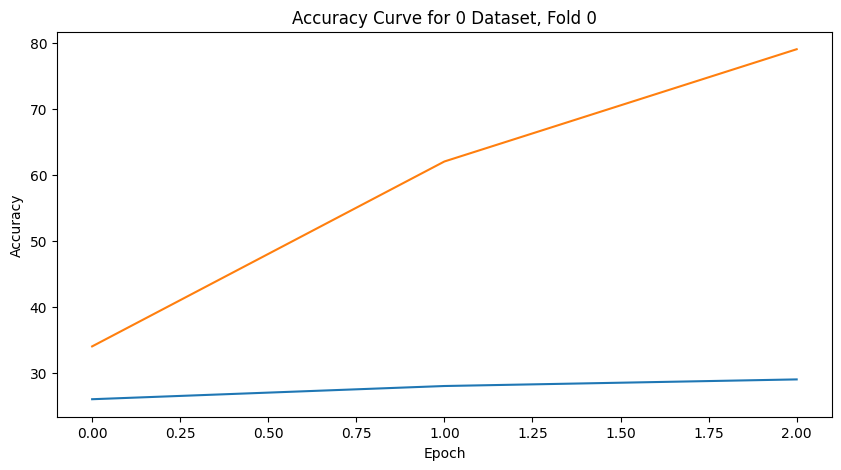

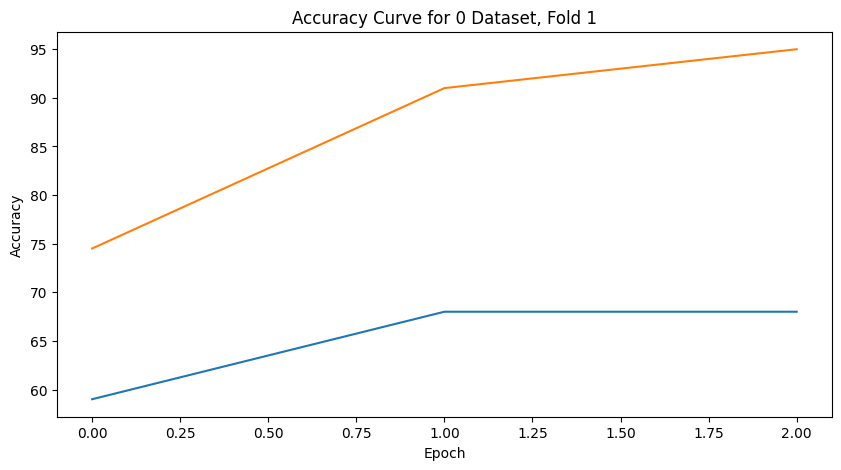

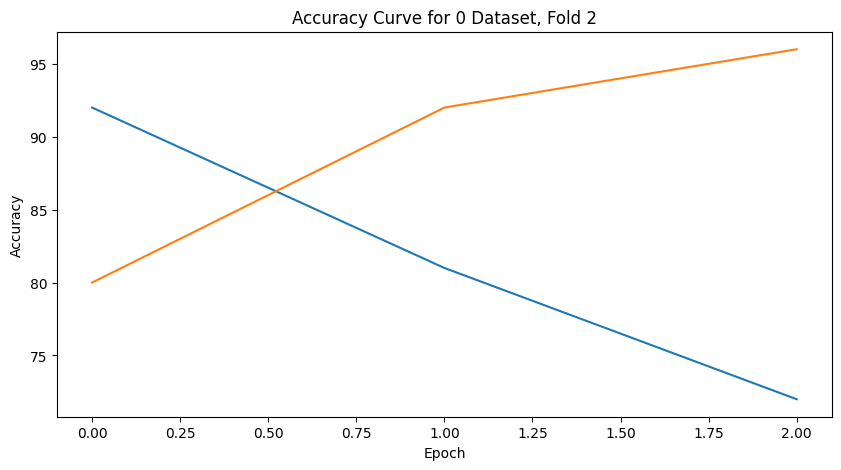

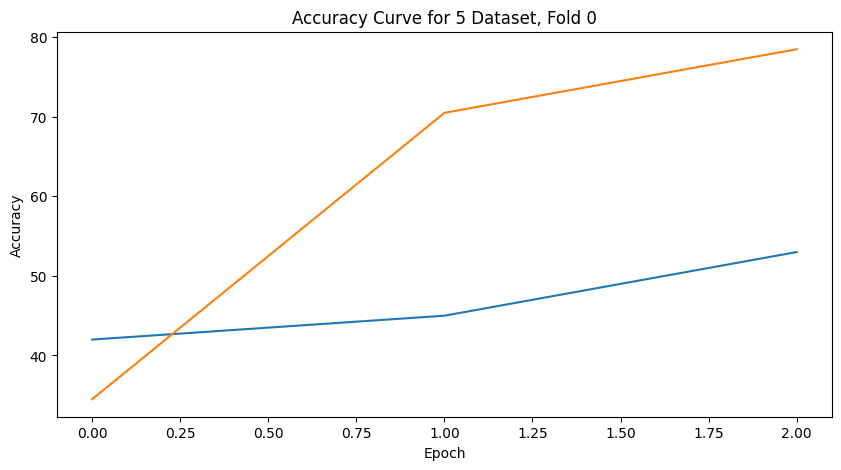

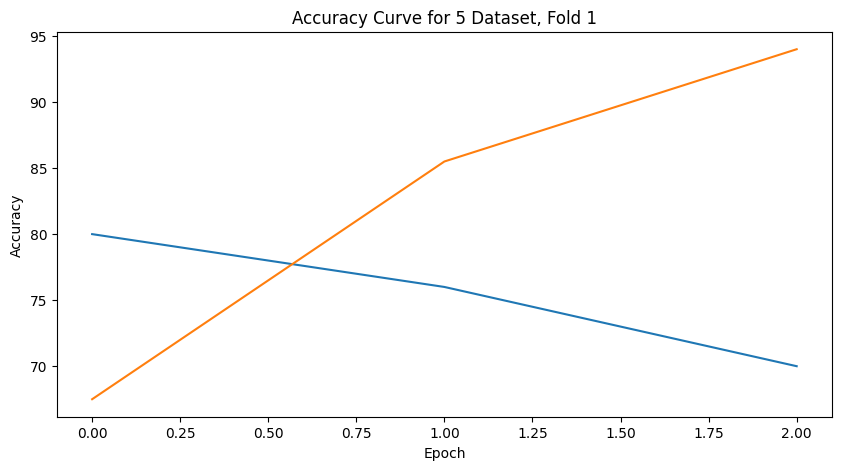

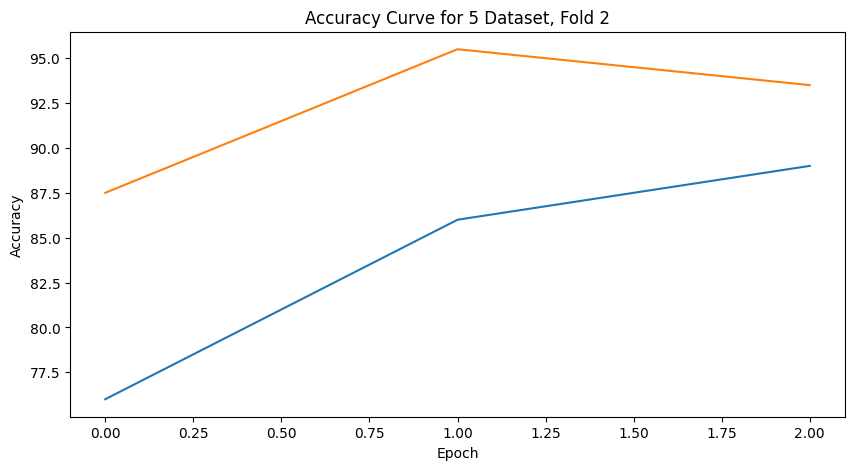

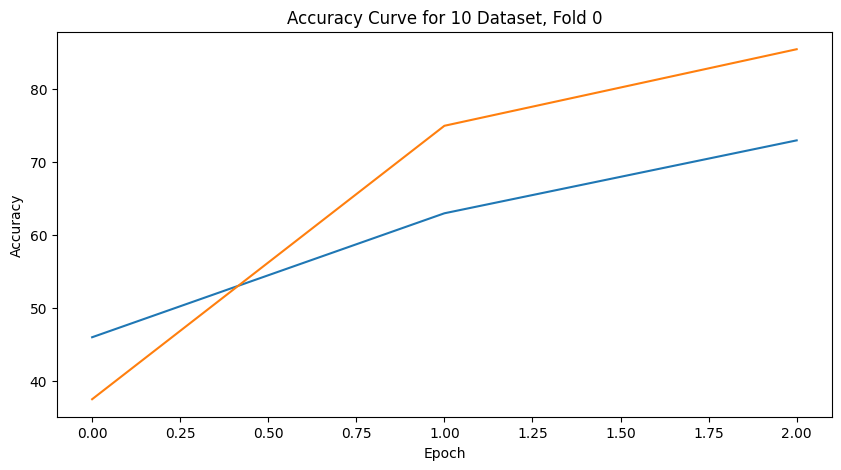

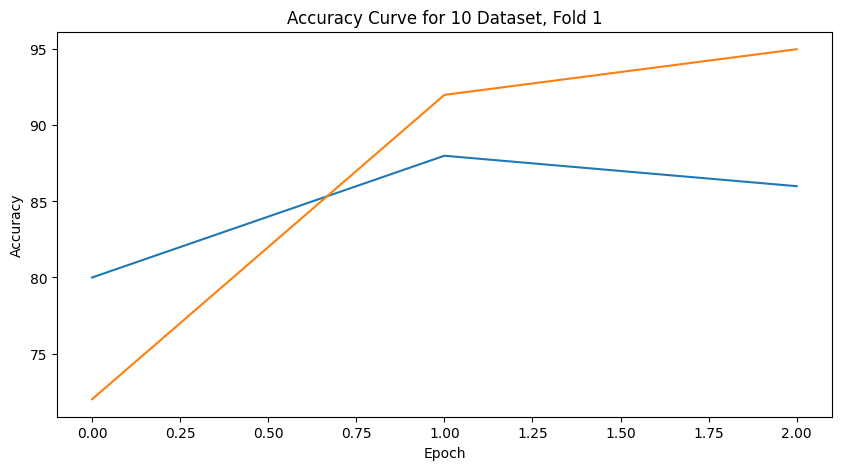

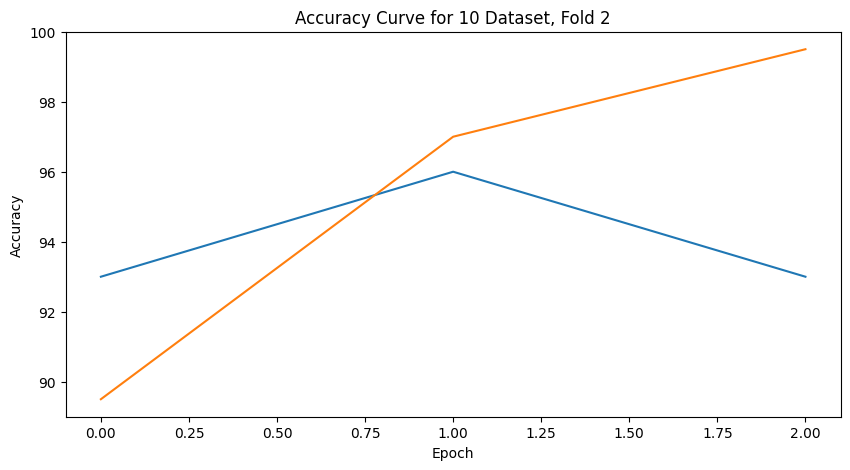

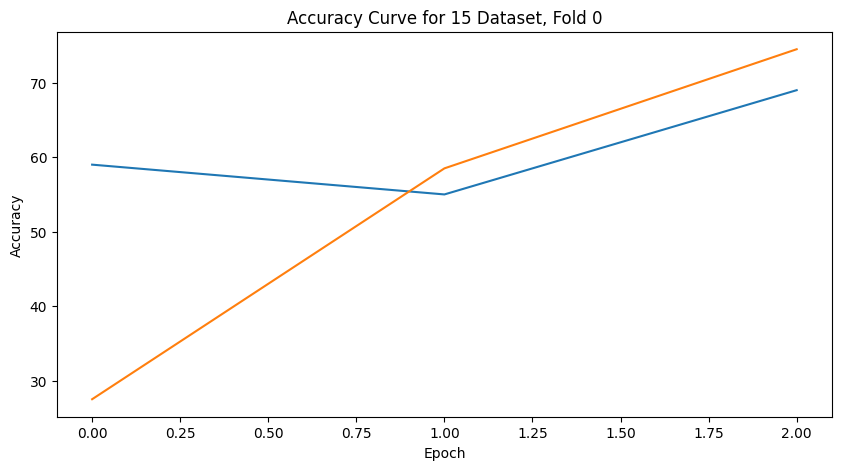

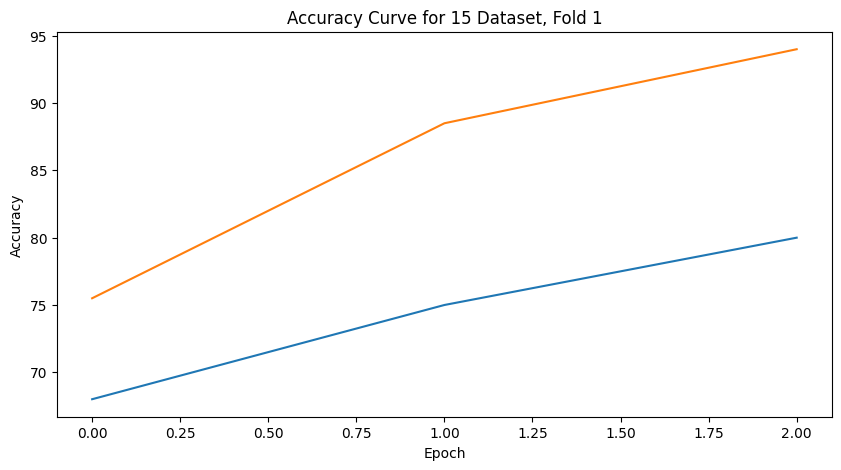

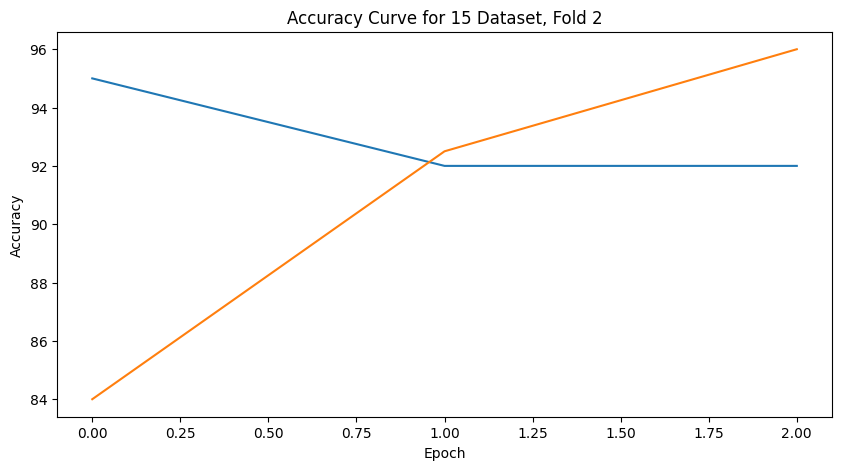

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu=nn.ReLU()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=8, kernel_size=(3,3), stride=1, padding=0)
        self.bn1=nn.BatchNorm2d(8)
        self.mp1=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.conv2=nn.Conv2d(in_channels=8,out_channels=16, kernel_size=(3,3), stride=1, padding=0)
        self.bn2=nn.BatchNorm2d(16)
        self.mp2=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.conv3=nn.Conv2d(in_channels=16,out_channels=16, kernel_size=(7,7), stride=1, padding=0)
        self.bn3=nn.BatchNorm2d(16)
        self.mp3=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)

        self.conv4=nn.Conv2d(in_channels=16,out_channels=32, kernel_size=(5,5), stride=1, padding=0)
        self.bn4=nn.BatchNorm2d(32)
        self.mp4=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
               
        self.flatten=nn.Flatten()

        self.lin1=nn.Linear(in_features=4608, out_features=64)
        self.bn5=nn.BatchNorm1d(num_features=64)
        self.lin2=nn.Linear(in_features=64, out_features=5)
        self.bn6=nn.BatchNorm1d(num_features=5)
            
    def forward(self,x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.mp1(x)
        
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu(x)
        x=self.mp2(x)
        
        x=self.conv3(x)
        x=self.bn3(x)
        x=self.relu(x)
        x=self.mp3(x)

        x=self.conv4(x)
        x=self.bn4(x)
        x=self.relu(x)
        x=self.mp4(x)

        x=self.flatten(x)

        x=self.lin1(x)
        x=self.bn5(x)
        x=self.relu(x)
        x=self.lin2(x)
        output=self.bn6(x)

        return output

model = CNN()
run_label_classification_one_vs_rest_fold(model, 0, 5)

The above downfall in lines is due to overfitting, this can be addressed further by adjusting the learning rate and adding regularisation as well as dropout layers

### Visualistaion

In [27]:
print(model)

CNN(
  (relu): ReLU()
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start

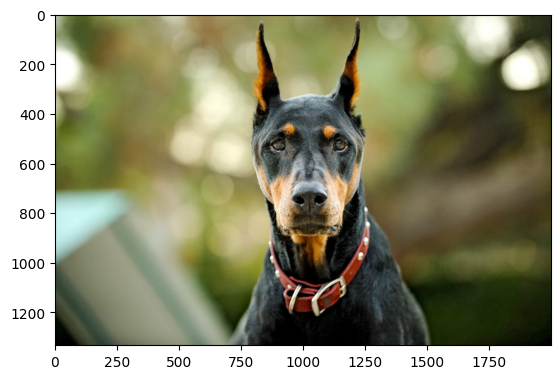

In [29]:
image = Image.open(str('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/dog/0be3797d3d.jpg'))
plt.imshow(image)

Total convolution layers: 4
conv_layers
Image shape before: torch.Size([3, 256, 256])
Image shape after: torch.Size([1, 3, 256, 256])
Image shape before: torch.Size([1, 3, 256, 256])
4
torch.Size([1, 8, 254, 254])
torch.Size([1, 16, 252, 252])
torch.Size([1, 16, 246, 246])
torch.Size([1, 32, 242, 242])
(254, 254)
(252, 252)
(246, 246)
(242, 242)


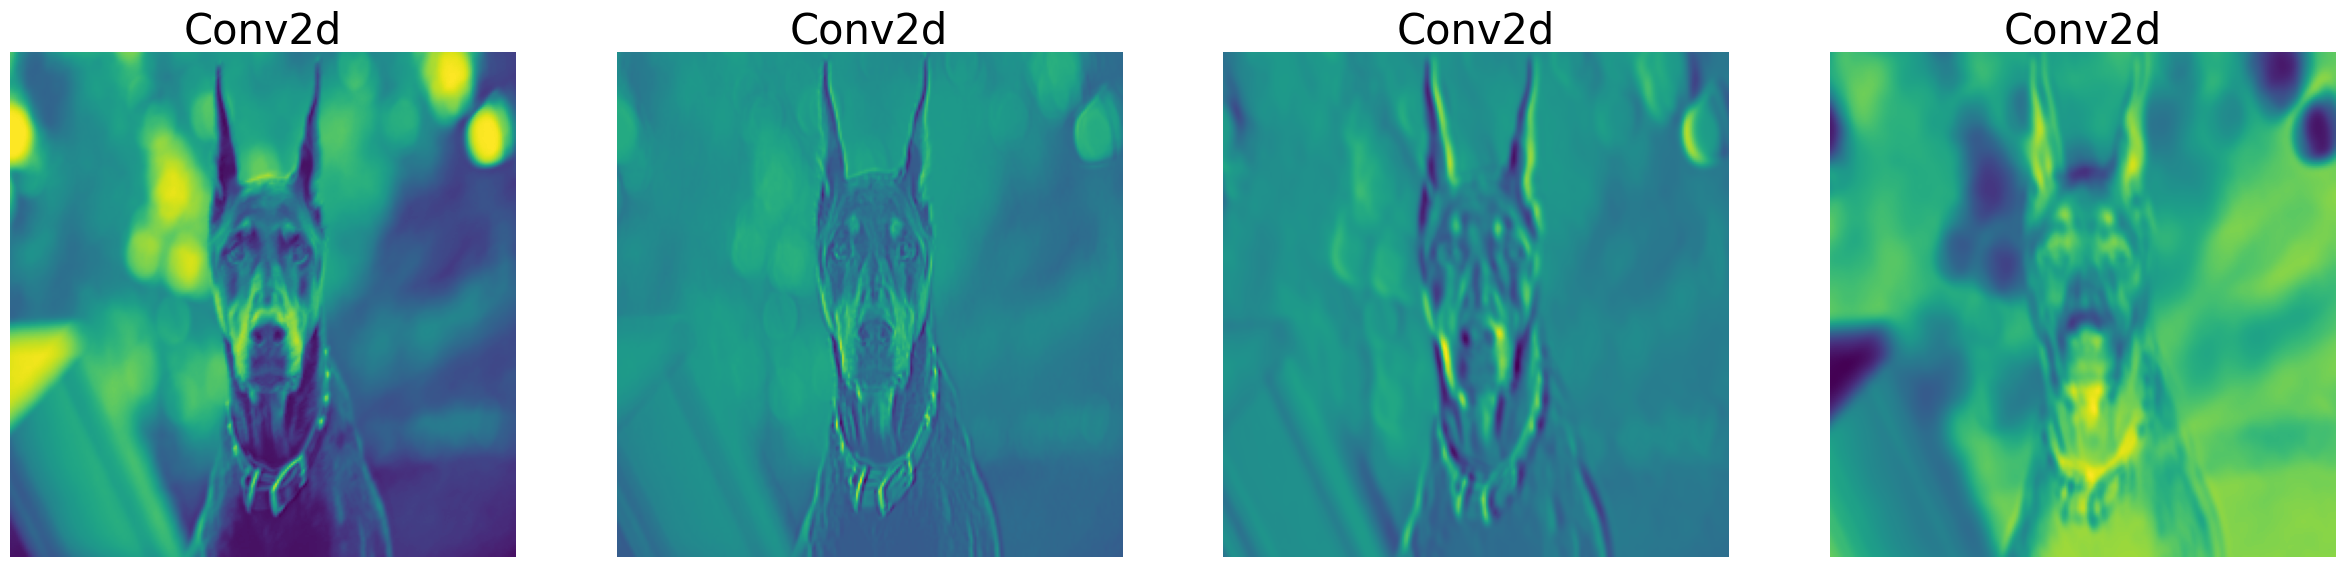

In [30]:
transforms = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

def nn_layer_visual(image, model):
        
        model_weights =[]
        conv_layers = []
        model_children = list(model.children())
        counter = 0
        for i in range(len(model_children)):
            if type(model_children[i]) == nn.Conv2d:
                counter+=1
                model_weights.append(model_children[i].weight)
                conv_layers.append(model_children[i])
            elif type(model_children[i]) == nn.Sequential:
                for j in range(len(model_children[i])):
                    for child in model_children[i][j].children():
                        if type(child) == nn.Conv2d:
                            counter+=1
                            model_weights.append(child.weight)
                            conv_layers.append(child)
        print(f"Total convolution layers: {counter}")
        print("conv_layers")

        image = transforms(image)
        print(f"Image shape before: {image.shape}")
        image = image.unsqueeze(0)
        print(f"Image shape after: {image.shape}")

        if len(image.shape) == 3:
            image = image.unsqueeze(0)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        image = image.to(device)

        print(f"Image shape before: {image.shape}")

        outputs = []
        names = []
        for layer in conv_layers[0:]:
            image = layer(image)
            outputs.append(image)
            names.append(str(layer))

        print(len(outputs))
        for feature_map in outputs:
            print(feature_map.shape)

        processed = []
        for feature_map in outputs:
            feature_map = feature_map.squeeze(0)
            gray_scale = torch.sum(feature_map,0)
            gray_scale = gray_scale / feature_map.shape[0]
            processed.append(gray_scale.data.cpu().numpy())
        for fm in processed:
            print(fm.shape)

        fig = plt.figure(figsize=(30, 50))
        for i in range(len(processed)):
            a = fig.add_subplot(5, 4, i+1)
            imgplot = plt.imshow(processed[i])
            a.axis("off")
            a.set_title(names[i].split('(')[0], fontsize=30)

nn_layer_visual(image, model)